In [1]:
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime

import scipy.signal as signal
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
def read_cesmLE(variable, time_interval):
    """ Read in CESM2 Large ensemble data. Returns an array that is ensemble member x time x space"""

    arrays = []
    for i in range(1,11):
        files = sorted(glob.glob('/glade/scratch/mollyw/external_data/CESM2_LE/daily/'+variable+'_d/b.e21.BHISTcmip6.f09_g17.LE2-1*[0-9]*.0{:0>2d}.*[0-9]*.nc'.format(i)))

        array_group = xr.open_mfdataset(files, combine='by_coords')

        arrays.append(array_group)

    final_array = xr.concat(arrays, dim = 'ensemble_member')
    return final_array

In [3]:
def difference(dataset, interval=1):
    """ Calculate the difference between two timesteps of a timeseries at a prescribed 
        interval.

        Inputs: xr.DataArray or xr.DataSet timeseries
        Output: differenced array as an xr.DataArray
    """

    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)

    diff_array = xr.DataArray(diff, 
                              coords=dataset.isel(time = slice(0,-1*interval)).coords, 
                              dims=dataset.isel(time = slice(0,-1*interval)).dims, 
                              attrs=dataset.isel(time = slice(0,-1*interval)).attrs
                             )
    return diff_array

def variability_in_window(timeseries, low, high):

    # determine filter
    fs = 1
    nyquist = fs / 2
    print('low cutoff= ',1/low*nyquist,' days')
    print('high cutoff= ',1/high*nyquist,' days')

    sos = signal.butter(5, [low, high], btype='bandpass', output='sos')

    filtered = signal.sosfiltfilt(sos, timeseries, axis = 0)
    filtered = xr.DataArray(filtered,
                            coords = timeseries.coords,
                            dims = timeseries.dims,
                            attrs = timeseries.attrs
                           )
    hfsit = filtered.groupby('time.month').std(dim='time')

    return hfsit

In [4]:
cesmle_vicen = read_cesmLE('vicen', 'day')
cesmle_vicen = cesmle_vicen.vicen_d[:, -365*10-1:len(cesmle_vicen.time), :, :, :]

In [5]:
cesmle_aicen = read_cesmLE('aicen', 'day')
cesmle_aicen = cesmle_aicen.aicen_d[:, -365*10-1:len(cesmle_aicen.time), :, :, :]

In [6]:
cesmle_thickness = (cesmle_vicen/cesmle_aicen).compute()

In [7]:
cesmle_mean = cesmle_thickness.where(cesmle_thickness > 0).mean(dim=['ensemble_member', 'ni', 'nj'])

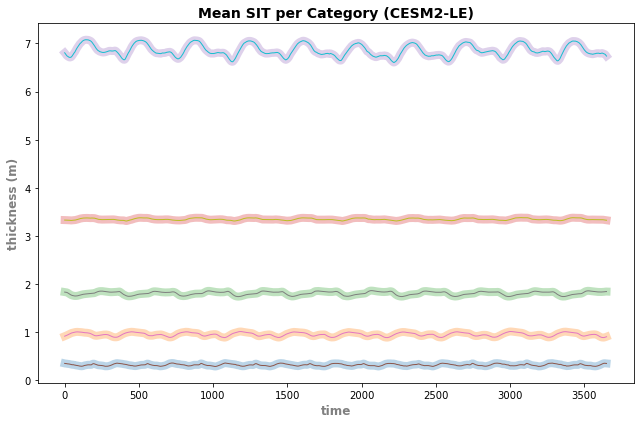

In [28]:
colors = plt.cm.YlGnBu(np.linspace(0, 1, 6))
figure = plt.figure(figsize=(9, 6))

plt.set_cmap(plt.cm.YlGnBu)

plt.plot(cesmle_mean, linewidth=8, alpha=0.3)
plt.plot(cesmle_mean, linewidth=1)

plt.xlabel('time', fontsize='12', fontweight='bold', color='grey')
plt.ylabel('thickness (m)', fontsize='12', fontweight='bold', color='grey')
plt.title('Mean SIT per Category (CESM2-LE)', fontsize='14', fontweight='bold')
# plt.legend(fontsize=12, frameon=False, ncol=2)
plt.tight_layout()

In [9]:
cesmle_var = cesmle_mean.var(dim = 'time')

In [23]:
bin_widths = np.flip(cesmle_var.NCAT).diff(dim = 'nc')

In [25]:
cesmle_var.NCAT

<xarray.DataArray 'NCAT' (nc: 5)>
array([6.4450723e-01, 1.3914335e+00, 2.4701793e+00, 4.5672879e+00,
       1.0000000e+08], dtype=float32)
Coordinates:
    NCAT     (nc) float32 0.6445 1.391 2.47 4.567 1e+08
Dimensions without coordinates: nc
Attributes:
    long_name:  category maximum thickness
    units:      m

In [49]:
labels  = [round(i,2) for i in cesmle_var.NCAT.values[:-1]]

In [51]:
labels.insert(0,0)

([<matplotlib.axis.XTick at 0x2b8d38b25a10>,
 [Text(1, 0, '0'),
  Text(2, 0, '0.64'),
  Text(3, 0, '1.39'),
  Text(4, 0, '2.47'),
  Text(5, 0, '4.57')])

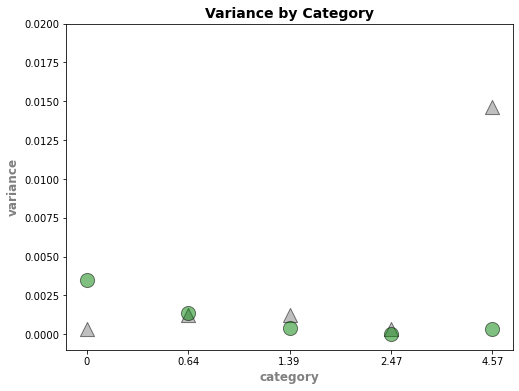

In [54]:
fig = plt.figure(figsize=(8,6))
plt.scatter(x = np.arange(1,6), y=cesmle_var, s = 200, c = 'grey', edgecolors = 'black', alpha = 0.5, marker = '^', label = 'normal ')
plt.scatter(x = np.arange(1,6), y=cesmle_var/(cesmle_mean.mean(dim='time')**2), s = 200, c = 'green', marker = 'o',
            edgecolors = 'black', alpha = 0.5, label = 'standardized')
plt.ylim([-0.001, 0.02])
plt.title('Variance by Category', fontweight='bold', fontsize=14)
plt.ylabel('variance', fontweight='bold', fontsize=12, color='grey')
plt.xlabel('category', fontweight='bold', fontsize=12, color='grey')
plt.xticks(np.arange(1,6), labels = labels)

In [ ]:
colors = plt.cm.YlGnBu(np.linspace(0, 1, 6))
figure = plt.figure(figsize=(9, 6))

plt.set_cmap(plt.cm.YlGnBu)

plt.plot(cesmle_var, linewidth=8, alpha=0.3)
plt.plot(cesmle_var, linewidth=1)

plt.xlabel('time', fontsize='12', fontweight='bold', color='grey')
plt.ylabel('thickness (m)', fontsize='12', fontweight='bold', color='grey')
plt.title('Mean SIT per Category (CESM2-LE)', fontsize='14', fontweight='bold')
# plt.legend(fontsize=12, frameon=False, ncol=2)
plt.tight_layout()

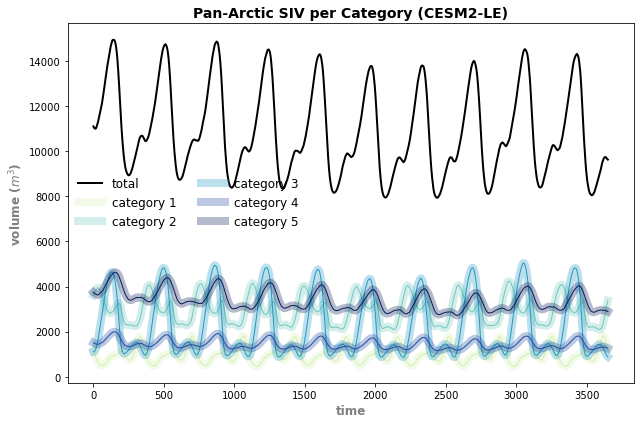

In [27]:
colors = plt.cm.YlGnBu(np.linspace(0,1,6))
figure = plt.figure(figsize=(9,6))

total = cesmle.sum(dim='nc')
total = total.mean(dim = 'ensemble_member')
total_mean = total.where(total > 0).sum(dim = ['ni','nj'])

plt.plot(total_mean, c = 'black', linewidth = 2, label = 'total')

for i in range(0,5):
    # grab the right category
    temp = cesmle.sel(nc = i)
    
    # average the category across ensemble members
    cesmle_cat = temp.mean(dim = 'ensemble_member')
    
    # average the ensemble mean across space (where the category is greater than zero)
    cat_mean = cesmle_cat.where(cesmle_cat > 0).sum(dim = ['ni','nj'])
    
    # plot category mean nicely
    plt.plot(cat_mean, c = colors[i+1], linewidth = 8, alpha = 0.3, label = 'category '+str(i+1))
    plt.plot(cat_mean, c = colors[i+1], linewidth = 1)
    

plt.xlabel('time', fontsize = '12', fontweight = 'bold', color = 'grey')
plt.ylabel('volume ($m^3$)', fontsize = '12', fontweight = 'bold', color = 'grey')
plt.title('Pan-Arctic SIV per Category (CESM2-LE)', fontsize = '14', fontweight = 'bold')
plt.legend(fontsize=12, frameon=False, ncol =2)
plt.tight_layout()

In [ ]:
cesmle_per_grid = cesmle.mean(dim = ['ensemble_member'])
# cesmle_vol_per_grid = cesmle.sum(dim = 'nc').mean(dim = ['ensemble_member'])

In [ ]:
# detrend and deseasonalize all data 
lens_volume = cesmle_per_grid.where(cesmle_per_grid.ULAT > 0).sum(dim=['ni','nj'])

# ensuring data is loaded into system 
lens_volume = lens_volume.compute()

# detrend
lens_detrended = lens_volume.diff(dim = 'time', n = 1)

# deseasonalize
lens_deseasonalized = difference(lens_detrended, 365)

In [ ]:
# detrend and deseasonalize all data 
lens_volume = cesmle_per_grid.where(cesmle_per_grid.ULAT > 0).sum(dim=['ni','nj'])

# ensuring data is loaded into system 
lens_volume = lens_volume.compute()

# detrend
lens_detrended = lens_volume.diff(dim = 'time', n = 1)

# deseasonalize
lens_deseasonalized = difference(lens_detrended, 365)

In [ ]:
colors = plt.cm.YlGnBu(np.linspace(0,1,6))
figure = plt.figure(figsize=(9,6))
plt.plot(lens_totdeseasonalized, c = 'black', alpha = 0.7,linewidth = 0.5, label= 'total thickness')
for i in range(0,5):    
    plt.plot(lens_deseasonalized[:,i], c= colors[i+1], linewidth = 2, alpha = 0.4, label = 'category '+str(i+1))

plt.xlabel('time', fontsize = '12', fontweight = 'bold', color = 'grey')
plt.ylabel('volume ($m^3$)', fontsize = '12', fontweight = 'bold', color = 'grey')
plt.title('Detrended/Deseasonalized SIV', fontsize = '14', fontweight = 'bold')
plt.legend(fontsize=12, frameon=False, ncol=2)
plt.tight_layout()

In [ ]:
deseasonalized = {'lens1':lens_deseasonalized[:,0], 
                  'lens2':lens_deseasonalized[:,1], 
                  'lens3':lens_deseasonalized[:,2],
                  'lens4':lens_deseasonalized[:,3],
                  'lens5':lens_deseasonalized[:,4]
                 }

In [ ]:
# set up a loop to calculate and plot the HFVSIV for each source of data
labels = ['lens1','lens2','lens3','lens4','lens5','total']
cutoffs = [1/6, 1/20, 1/40, 1/60, 1/80, 1/100, 1/120]
HFSIT = {}

months = ['J','F','M','A','May','Jun','Jul','Aug','S','O','N','D']
# months = ['DJF','MAM','JJA','SON']
days = [0,10, 20,30,40,50]

for label in labels:
    # if label != 'obs':
    #     timeseries = deseasonalized[label]*10
    # else:
    #     timeseries = deseasonalized[label]
    
    timeseries = deseasonalized[label]
    
    # initalize list for each window
    list_hfsit = []

    # solve each window and append to list
    for i in range(0, len(cutoffs[:-1])):
        hfsit = variability_in_window(timeseries, cutoffs[i+1], cutoffs[i])
        list_hfsit.append(hfsit)
        
    # combine records 
    HFSIT[label] = xr.concat(list_hfsit, dim = 'intervals')
    
    if label == 'obs':
        HFSIT[label][:,4:9] = 'nan'

    fig = plt.figure(figsize = (6, 6))

    cmap = plt.cm.YlOrRd
    # norm = colors.BoundaryNorm(np.arange(0, 100, 5), cmap.N)

    plt.pcolormesh(months, days, HFSIT[label], vmin = 0, vmax = 5, cmap = cmap)
    plt.colorbar()

In [ ]:
model = HFSIT['total']
# model[:,4:9]='nan'
obs = HFSIT['lens5']

In [ ]:
diff = obs - model
ratio = obs/model

In [ ]:
# plot the heatmap-- eventually get seaborn to do this, it's prettier
months = ['J','F','M','A','May','Jun','Jul','Aug','S','O','N','D']
# months = ['DJF','MAM','JJA','SON']
days = [0,10, 20,30,40,50]

fig = plt.figure(figsize = (6, 6))

cmap = plt.cm.RdYlBu_r
# norm = colors.BoundaryNorm(np.arange(-50,51,5), cmap.N)

plt.pcolormesh(months, days, diff, vmin = -3, vmax = 3, cmap = cmap)
plt.colorbar()

In [ ]:
# plot the heatmap-- eventually get seaborn to do this, it's prettier
months = ['J','F','M','A','May','Jun','Jul','Aug','S','O','N','D']
# months = ['DJF','MAM','JJA','SON']
days = [0,10, 20,30,40,50]

fig = plt.figure(figsize = (6, 6))

cmap = plt.cm.RdYlGn
# norm = colors.BoundaryNorm(np.linspace(0, 10, 21), cmap.N)

plt.pcolormesh(months, days, ratio, vmin = 0 , vmax = 2, cmap = cmap)
plt.colorbar()

In [ ]:
fw = 1.2
for label in labels:
    timeseries = deseasonalized[label]
    # if label == 'obs':
    #     timeseries = timeseries/10
    # elif label == 'piomas':
    #     timeseries = timeseries/5
        
    f0, Pxx0 = signal.welch(timeseries, fs=1, window = 'hann', nperseg=128, detrend = False, axis = 0)
    
    a0 = sm.tsa.acf(timeseries)[1]

    N = len(timeseries)
    M = 128
    dof = 2*N/M*fw
    
    f_stat = stats.f.ppf(0.95, dof, dof)

    red0 = [(1-a0**2)/(1-2*a0*np.cos(omega)+a0**2) for omega in np.linspace(0, np.pi, len(f0))]
    ratio0 = sum(Pxx0)/sum(red0)
    Red0 = [r0*ratio0*f_stat for r0 in red0]
    
    fig = plt.figure()
    plt.plot(f0, Pxx0)
    plt.plot(f0, Red0)
    plt.xlim([0.0, 0.5])
    # plt.ylim([0, 5000])
    
    indexes = np.where(Pxx0 - Red0 > 0)
    # print(indexes)
    periods = [1/f0[i] for i in indexes]
    print(periods[0])